# Tutorial on adding own data as a reaction dependent component
Properties are calculated using the modified Ryzhenko-Bryzgalin (MRB) model, see Gems3-app/Resources/doc/pdf/T-corrections-Reac.pdf

### Import thermohubclient, thermofun, and get the conncetion to the remote database

In [1]:
import thermohubclient as client
import thermofun as fun
dbc = client.DatabaseClient()

### Get mines19 database to thermofun database

In [2]:
mines19db = fun.Database(dbc.getDatabase("mines19"))

### Add a reaction as JSON string
{
  "TPMethods":[ ],
  "datasources":"",
  "equation":"",
  "symbol":""
}

### print available methods

In [3]:
print(fun.availableReactionTPMethods())

{"method": {"0": "logk_fpt_function"}, "logk_ft_coeffs" : { "values": []}}
{"method": {"3": "logk_nordstrom_munoz88"}, "logk_ft_coeffs" : { "values": []}}
{"method": {"4": "logk_1_term_extrap0"}, "logk_ft_coeffs" : { "values": []}}
{"method": {"5": "logk_1_term_extrap1"}, "logk_ft_coeffs" : { "values": []}}
{"method": {"6": "logk_2_term_extrap"}, "logk_ft_coeffs" : { "values": []}}
{"method": {"7": "logk_3_term_extrap"}, "logk_ft_coeffs" : { "values": []}}
{"method": {"8": "logk_lagrange_interp"}}
{"method": {"9": "logk_marshall_frank78"}, "dr_marshall_franck_coeffs" : { "values": []}}
{"method": {"10": "solute_eos_ryzhenko_gems"}, "dr_ryzhenko_coeffs" : { "values": []}}
{"method": {"11": "dr_heat_capacity_ft"}, "dr_heat_capacity_ft_coeffs" : { "values": []}}
{"method": {"12": "dr_volume_fpt"}, "dr_volume_fpt_coeffs" : { "values": []}}
{"method": {"13": "dr_volume_constant"}}
{"method": {"14": "logk_dolejs_manning10"}, "dr_dolejs_manning10_coeffs" : { "values": []}}



### Add LaSO4+_mi = La+3 + SO4-2 reaction from Migdisov et al., 2016 paper, see file LaSO4-reaction.json

In [4]:
mines19db.setReaction('''
{
  "TPMethods":[
    {
      "dr_ryzhenko_coeffs":{
        "values":[
          3.61,
          1.563,
          -193.7
        ]
      },
      "method":{
        "10":"solute_eos_ryzhenko_gems"
      }
    }
  ],
  "datasources":"Migdisov et al., 2016",
  "equation":"LaSO4+_mi = La+3 + SO4-2",
  "symbol":"LaSO4+_mi"
}
''')

### create a batch object,set units digits for 'logKr', print(fun.availablePropertiesReaction())

In [5]:
batch = fun.ThermoBatch(mines19db)
batch.setPropertiesUnits(["temperature", "pressure"],["degC","bar"])
batch.setPropertiesDigits(["logKr"], [4])

### set pressure and temperature incremenets

In [6]:
batch.setPressureIncrement(0,0,0)
batch.setTemperatureIncrement(0,300, 5)

### calculate logK of ["LaSO4+_mi", "La(SO4)+ = La+3 + SO4-2"], new and from mines19

In [7]:
batch.thermoPropertiesReaction(["LaSO4+_mi", "La(SO4)+ = La+3 + SO4-2"], ["logKr"]).toCSV("res.csv")

### plot resuts 'from functions import plot_properties_vs_temperature'
plot_properties_vs_temperature('res.csv', ["LaSO4+_mi", "La(SO4)+ = La+3 + SO4-2"], 0)

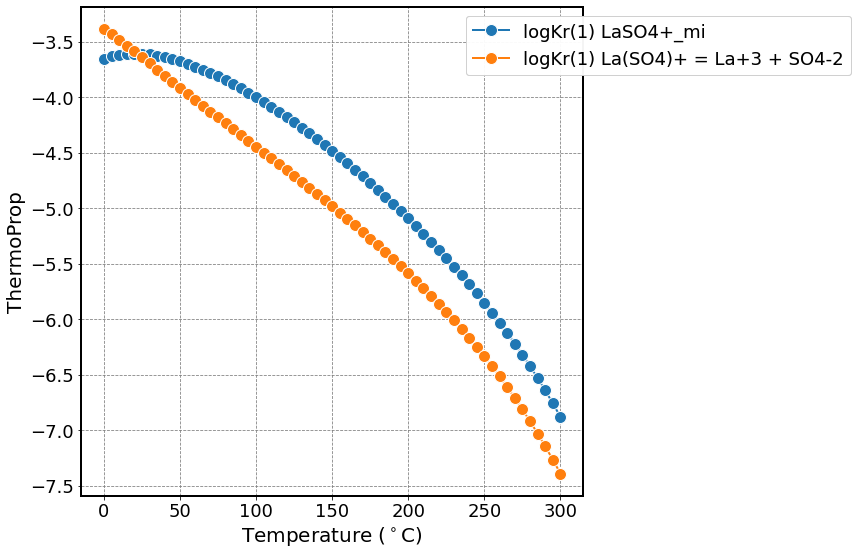

In [8]:
from common.functions import plot_properties_vs_temperature
plt = plot_properties_vs_temperature('res.csv', ["LaSO4+_mi", "La(SO4)+ = La+3 + SO4-2"], 0)
#plt.ylim(-5, 0)
#plt.legend(loc = "upper left")

### add substance as reaction dependent see LaSO4-reaction_dependent_substance.json

In [9]:
mines19db.setSubstance('''
        {
            "symbol": "LaSO4+_mi",
            "formula": "LaSO4+",
            "reaction": "LaSO4+_mi"
        }
''')

### create an engine object and calculate properties at 498.15, 0 (Psat) for "La(SO4)+" and "LaSO4+_mi"

In [10]:
engine = fun.ThermoEngine(mines19db)

In [11]:
props1 = engine.thermoPropertiesSubstance(498.15, 0, "La(SO4)+")
props2 = engine.thermoPropertiesSubstance(498.15, 0, "LaSO4+_mi")

In [12]:
props1.gibbs_energy.val

-1426377.7370179314

In [13]:
props2.gibbs_energy.val

-1421756.7677983388

### Calculate solvent properties

In [14]:
res =engine.propertiesSolvent(473, 2000e5, "H2O@")

In [15]:
res.density.val

966.4981340923547

In [16]:
res.densityT.val

-0.7473776229170155

In [17]:
res.density.ddt

-0.7473776229170166

### Append to engine engine.appendData("mydata-thermofun.json") and calculate logK of "NdSO4+_mi"

In [19]:
engine.appendData("mydata-thermofun.json")

In [20]:
props3 = engine.thermoPropertiesReaction(498.15, 0, "NdSO4+_mi")

In [21]:
props3.log_equilibrium_constant.val

-5.785642465716963